<a href="https://colab.research.google.com/github/georgilos/Bert-for-text-classification/blob/main/SPAL%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cloning the repository containing itinial training data, evaluation & unlabeled data

In [1]:
!git clone https://github.com/georgilos/Bert-for-text-classification.git

Cloning into 'Bert-for-text-classification'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 178 (delta 18), reused 18 (delta 7), pack-reused 137 (from 1)
Receiving objects: 100% (178/178), 37.23 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (67/67), done.


### Changing directory


In [2]:
%cd Bert-for-text-classification/

/content/Bert-for-text-classification


In [6]:
%ls

Active+BERT.ipynb            diversity_sampling.py  pytorch_clusters.py   uncertainty_sampling.py
active_learning_basics.py    eval_embeddings.npy    README.md             unlabeled_data/
active_learning.py           evaluation_data/       requirements.txt      unlabeled_embeddings.npy
advanced_active_learning.py  LICENSE                train_embeddings.npy  validation_data/
combined_embeddings.npy      models/                training_data/


### Checking gpu is on

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Reading the .csv files


In [3]:
import pandas as pd

# Load training data
train_hate = pd.read_csv('training_data/related.csv', header=None)
train_non_hate = pd.read_csv('training_data/not_related.csv', header=None)

# Load evaluation data
eval_hate = pd.read_csv('evaluation_data/related.csv', header=None)
eval_non_hate = pd.read_csv('evaluation_data/not_related.csv', header=None)

# Load unlabeled data
unlabeled_data = pd.read_csv('unlabeled_data/unlabeled_data.csv', header=None)

# Assign column names
columns = ['ID', 'TEXT', 'LABEL', 'UNKNOWN1', 'UNKNOWN2']
train_hate.columns = train_non_hate.columns = eval_hate.columns = eval_non_hate.columns = columns
unlabeled_data.columns = ['ID', 'TEXT']  # Unlabeled data doesn't have LABEL

# Keep only relevant columns
train_hate = train_hate[['ID', 'TEXT', 'LABEL']]
train_non_hate = train_non_hate[['ID', 'TEXT', 'LABEL']]
eval_hate = eval_hate[['ID', 'TEXT', 'LABEL']]
eval_non_hate = eval_non_hate[['ID', 'TEXT', 'LABEL']]
unlabeled_data = unlabeled_data[['ID', 'TEXT']]  # Unlabeled data has no labels

# Combine training and evaluation data
train_data = pd.concat([train_hate, train_non_hate], ignore_index=True)
eval_data = pd.concat([eval_hate, eval_non_hate], ignore_index=True)

# Inspect the datasets
print("Training Data:")
print(train_data.head())
print("Evaluation Data:")
print(eval_data.head())
print("Unlabeled Data:")
print(unlabeled_data.head())


Training Data:
         ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1
2  10119028                     lol you sick whiny tds pussies      1
3  10536279  she is a dumbass a public embarrassment for he...      1
4  10236262  i wanted to reply lets goooooo brandon but i d...      1
Evaluation Data:
       ID                                               TEXT  LABEL
0  585871  bitch i turn on the tv and is drunk af also ho...      1
1  215768  hicks and hillbillies are taking over the repu...      1
2  311431  the whole bunch is pure trash including the se...      1
3  452016  these gay drunk dudes on are very embarrassing...      1
4  109292  this dude is drunk af and crosseyed on in the ...      1
Unlabeled Data:
         ID                                               TEXT
0  10000000  if youre going down might as well go down in f..

###Checking the data contents



In [24]:
print( train_data.iloc[9])

ID                                          10942227
TEXT     twitter is retarded and they aren't doctors
LABEL                                              1
Name: 9, dtype: object


### Must - link pairs

In [16]:
from itertools import combinations

def generate_must_link(data):
    same_class_pairs = []
    for label in data['LABEL'].unique():
        subset = data[data['LABEL'] == label]
        same_class_pairs.extend(list(combinations(subset.index, 2)))
    return same_class_pairs

must_link_pairs = generate_must_link(train_data)
print("First 5 Must-Link Pairs:", must_link_pairs[:5])  # Show first 5 pairs
print ("Totat Must-Link Pairs:", len(must_link_pairs))

First 5 Must-Link Pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Totat Must-Link Pairs: 3615


### Checking the contents of a must-link pair

In [34]:
# Access the contents of the first must-link pair
first_pair = must_link_pairs[0]
print("First Must-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Must-Link Pair:\n", first_pair_data)

First Must-Link Pair Indices: (0, 1)

Data for the first Must-Link Pair:
          ID  \
0  10241698   
1  10238878   

                                                                                                                                                                                               TEXT  \
0                                                                                                employees are either pedophiles or trying to recruit gay men to pleasure their gay anchors at whim   
1  how about this lets go to retard war lets see who gets nuked first cause thats what we want right lets go pussies man up and kill all of us tired of all this bullshit you guys keep lying about   

   LABEL  
0      1  
1      1  


### Cannot - link pairs

In [35]:
def generate_cannot_link(data):
    hate_indices = data[data['LABEL'] == 1].index
    non_hate_indices = data[data['LABEL'] == 0].index
    return [(i, j) for i in hate_indices for j in non_hate_indices]

cannot_link_pairs = generate_cannot_link(train_data)
print("First 5 Cannot-Link Pairs:", cannot_link_pairs[:5])  # Show first 5 pairs
print ("Total Cannot-Link Pairs:", len(cannot_link_pairs))

First 5 Cannot-Link Pairs: [(0, 10), (0, 11), (0, 12), (0, 13), (0, 14)]
Total Cannot-Link Pairs: 850


### Checking the contents of a cannot-link pair

In [36]:
# Access the contents of the first cannot-link pair
first_pair = cannot_link_pairs[0]
print("First Cannot-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Cannot-Link Pair:\n", first_pair_data)

First Cannot-Link Pair Indices: (0, 10)

Data for the first Cannot-Link Pair:
           ID  \
0   10241698   
10  10410961   

                                                                                                  TEXT  \
0   employees are either pedophiles or trying to recruit gay men to pleasure their gay anchors at whim   
10                                                           except on foreign soil not the same thing   

    LABEL  
0       1  
10      0  


### Creating BERT embedding of the data

In [39]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):

    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)


# Generate embeddings for labeled data (train_data)
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for unlabeled data
unlabeled_texts = unlabeled_data['TEXT'].tolist()
unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


### Save embeddings

In [62]:
# Save train embeddings
torch.save(train_embeddings, 'train_embeddings.pt')

# Save unlabeled embeddings
torch.save(unlabeled_embeddings, 'unlabeled_embeddings.pt')


### Download them

In [178]:
from google.colab import files

files.download('/content/Bert-for-text-classification/unlabeled_embeddings.pt')
files.download('/content/Bert-for-text-classification/train_embeddings.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load embeddings (if downloaded from last session)

In [63]:
import torch

# Paths to the saved .pt files
train_embeddings_path = 'train_embeddings.pt'
unlabeled_embeddings_path = 'unlabeled_embeddings.pt'

# Load the embeddings
train_embeddings = torch.load(train_embeddings_path)
unlabeled_embeddings = torch.load(unlabeled_embeddings_path)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


<ipython-input-63-dea01f3a36cb>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load(train_embeddings_path)
<ipython-input-63-dea01f3a36cb>:9: Futu

### Combine embeddings

In [64]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, unlabeled_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)


Combined Embeddings Shape: torch.Size([5096, 768])


### Compute the pairwise distances between all embeddings

In [66]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)


Distance Matrix Shape: (5096, 5096)


### Constrained DBSCAN


In [179]:
import numpy as np
from collections import deque

def constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link, cannot_link):
    """
    Constrained DBSCAN implementation where constraints are applied during clustering.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix.
    - eps (float): Maximum distance to consider two points as neighbors.
    - min_samples (int): Minimum number of neighbors for a point to be a core point.
    - must_link (list of tuples): List of must-link pairs (index1, index2).
    - cannot_link (list of tuples): List of cannot-link pairs (index1, index2).

    Returns:
    - labels (ndarray): Cluster labels for each point. Noise is labeled as -1.
    """
    n = distance_matrix.shape[0]
    labels = np.full(n, -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Convert must-link and cannot-link constraints into dictionaries for quick lookup
    must_link_dict = {i: set() for i in range(n)}
    for i, j in must_link:
        must_link_dict[i].add(j)
        must_link_dict[j].add(i)

    cannot_link_dict = {i: set() for i in range(n)}
    for i, j in cannot_link:
        cannot_link_dict[i].add(j)
        cannot_link_dict[j].add(i)

    # Visit each point
    visited = np.full(n, False)

    def expand_cluster(point_idx):
        queue = deque([point_idx])
        cluster_points = []

        while queue:
            current_point = queue.popleft()
            if visited[current_point]:
                continue
            visited[current_point] = True
            cluster_points.append(current_point)

            # Get neighbors of the current point
            neighbors = np.where(distance_matrix[current_point] <= eps)[0]

            # Ensure cannot-link constraints are not violated
            valid_neighbors = []
            for neighbor in neighbors:
                # Check for indirect cannot-link violations
                if any(
                    neighbor in cannot_link_dict[other_point] for other_point in cluster_points
                ):
                    continue  # Skip this neighbor, as it creates an indirect cannot-link violation
                valid_neighbors.append(neighbor)

            print(f"Point {current_point}: {len(neighbors)} neighbors before filtering, {len(valid_neighbors)} after filtering.")
            neighbors = valid_neighbors

            # Add must-link neighbors to the cluster and queue
            for p in must_link_dict[current_point]:
                if p not in cluster_points:
                    queue.append(p)

            # If the current point has enough neighbors, include them in the cluster
            if len(neighbors) >= min_samples:
                for neighbor in neighbors:
                    if neighbor not in cluster_points:
                        queue.append(neighbor)

        # Assign the cluster ID to all points in the cluster
        for p in cluster_points:
            labels[p] = cluster_id


    for i in range(n):
        if visited[i] or labels[i] != -1:  # Skip visited or already clustered points
            continue

        # Check if the point is a core point
        neighbors = np.where(distance_matrix[i] <= eps)[0]
        if len(neighbors) < min_samples:
            continue  # Not a core point, remains noise

        # Expand the cluster
        expand_cluster(i)
        cluster_id += 1

    return labels

### Running constrained DBSCAN with eps and min_samples parameters

In [180]:
# Apply constrained DBSCAN
eps = 0.09  # Adjust based on distance matrix
min_samples = 5  # Minimum neighbors to form a cluster

adjusted_labels = constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link_pairs, cannot_link_pairs)
print("Adjusted Cluster Labels:", np.unique(adjusted_labels))


Point 2: 722 neighbors before filtering, 714 after filtering.
Point 0: 1 neighbors before filtering, 1 after filtering.
Point 1: 1 neighbors before filtering, 1 after filtering.
Point 3: 2 neighbors before filtering, 2 after filtering.
Point 4: 1 neighbors before filtering, 1 after filtering.
Point 5: 89 neighbors before filtering, 89 after filtering.
Point 6: 1055 neighbors before filtering, 1042 after filtering.
Point 7: 1 neighbors before filtering, 1 after filtering.
Point 8: 2 neighbors before filtering, 2 after filtering.
Point 9: 2 neighbors before filtering, 2 after filtering.
Point 105: 1364 neighbors before filtering, 1349 after filtering.
Point 114: 1646 neighbors before filtering, 1629 after filtering.
Point 118: 812 neighbors before filtering, 802 after filtering.
Point 119: 1368 neighbors before filtering, 1352 after filtering.
Point 121: 1678 neighbors before filtering, 1657 after filtering.
Point 124: 335 neighbors before filtering, 332 after filtering.
Point 125: 1007 

### Visualisation

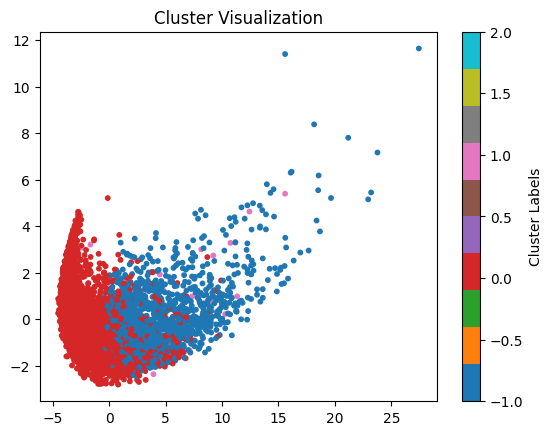

In [183]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
reduced_embeddings = PCA(n_components=2).fit_transform(distance_matrix)

# Plot clusters
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=adjusted_labels, cmap='tab10', s=10
)
plt.colorbar(label="Cluster Labels")
plt.title("Cluster Visualization")
plt.show()



### Checking for must-link & cannot-link violations

In [181]:
violations = []
for idx1, idx2 in cannot_link_pairs:
    if adjusted_labels[idx1] == adjusted_labels[idx2] and adjusted_labels[idx1] != -1:
        violations.append((idx1, idx2))

print(f"Cannot-Link Violations: {len(violations)}")
if violations:
    print("Sample Violations:", violations[:5])  # Print a few examples


Cannot-Link Violations: 0


In [182]:
violations = []
for idx1, idx2 in must_link_pairs:
    if adjusted_labels[idx1] != adjusted_labels[idx2]:
        violations.append((idx1, idx2))

print(f"Must-Link Violations: {len(violations)}")
if violations:
    print("Sample Violations:", violations[:5])  # Print a few examples


Must-Link Violations: 0


### Number of noise points

In [185]:
noise_points = [i for i, label in enumerate(adjusted_labels) if label == -1]
print(f"Number of Noise Points: {len(noise_points)}")


Number of Noise Points: 1347


In [184]:
total_points = len(adjusted_labels)
noise_percentage = len(noise_points) / total_points * 100
print(f"Percentage of Noise Points: {noise_percentage:.2f}%")


Percentage of Noise Points: 25.55%


In [186]:
print(f"Sample Noise Points: {noise_points[:10]}")


Sample Noise Points: [96, 101, 103, 108, 109, 110, 117, 120, 122, 123]


In [187]:
# Noise in must-link pairs
noise_in_must_link = [pair for pair in must_link_pairs if pair[0] in noise_points or pair[1] in noise_points]
print(f"Noise Points in Must-Link Pairs: {len(noise_in_must_link)}")

# Noise in cannot-link pairs
noise_in_cannot_link = [pair for pair in cannot_link_pairs if pair[0] in noise_points or pair[1] in noise_points]
print(f"Noise Points in Cannot-Link Pairs: {len(noise_in_cannot_link)}")


Noise Points in Must-Link Pairs: 0
Noise Points in Cannot-Link Pairs: 0


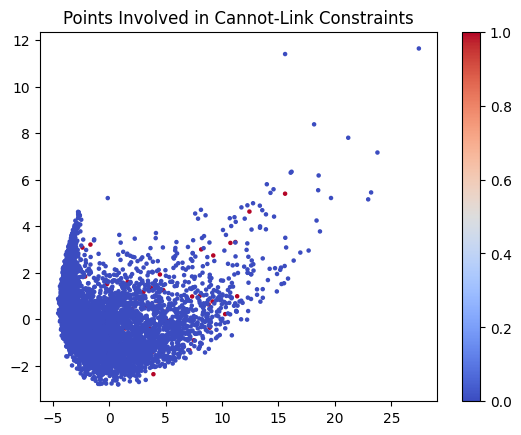

In [188]:
# Extract points involved in cannot-link constraints
cannot_link_indices = set([idx for pair in cannot_link_pairs for idx in pair])

# Visualize the positions of these points
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=[1 if i in cannot_link_indices else 0 for i in range(len(reduced_embeddings))],
    cmap='coolwarm', s=5
)
plt.colorbar()
plt.title("Points Involved in Cannot-Link Constraints")
plt.show()
